# Setup

We model the datasets as lists of indices to the `torch.Tensor X` and `torch.Tensor y`, which have length `m`. The `datasets_workers` is a list of lists, which contain indices to the global dataset.

The different scenarios are run in the Simulations section. You can change the parameters of the simulations in the cell titled Parameters for simulations.

In [1]:
# Import the necessary libraries
from itertools import chain
from random import shuffle, sample

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Load the MNIST dataset
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),  # convert the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),  # normalize
        ]
    ),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),  # convert the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),  # normalize
        ]
    ),
)

In [2]:
# Parameters about data (these should not be changed!)
n_labels = 10  # number of labels is 10 in the MNIST data set
n_workers = 10  # number of clients is 10

m_data = 300  # total number of data points
m_test = 500  # total number of test data points

# it should be possible to distribute the same number of data points of each label at each worker
assert m_data % (n_workers * n_labels) == 0

# number of data points per label
m_labels = m_data // n_labels

In [3]:
# Parameters for simulations (these can be changed)
n_sim = 1000  # number of simulations for each scenario
n_iter = 50   # number of iterations for each simulation

# Concentration parameter for the Dirichlet distribution
alpha = 0.1

# Lists of different straggling probabilities p, non-private data shares c, and replication factors d
num_cd_scenarios = 5
num_p_scenarios = 3

p_cd_list = [
    (0.3, [(0.1, 2), (0.2, 2), (0.3, 2), (0.4, 2), (0.5, 2)]),
    (0.5, [(0.1, 3), (0.2, 3), (0.3, 3), (0.4, 3), (0.5, 3)]),
    (0.7, [(0.1, 4), (0.2, 4), (0.3, 4), (0.4, 4), (0.5, 4)]),
]

In [4]:
# Load the entire dataset in a nice format
X = training_data.data.reshape(-1, 28 * 28).float()
y = training_data.targets

# Trim the dataset down to what is needed
X = torch.cat([X[y == l][:m_labels] for l in range(n_labels)])
y = torch.cat([y[y == l][:m_labels] for l in range(n_labels)])

# Load the test dataset
X_test = test_data.data.reshape(-1, 28 * 28).float()[:m_test]
y_test = test_data.targets[:m_test]

In [5]:
def concatenate(lists):
    """Given an iterable of lists, return the concatenation of the lists"""

    return list(chain(*lists))


def get_indices(cond):
    """Get the indices where cond is True"""

    return np.arange(len(cond))[cond].tolist()


def get_replication_counts(datasets_workers):
    """Get the replication count of each of the data points at the workers"""

    counts_all = torch.zeros(m_data)
    for dataset in datasets_workers:
        counts_all[dataset] += 1

    return counts_all


def get_weights(datasets_workers):
    """Get the weight vectors for each worker"""

    replication_counts = get_replication_counts(datasets_workers)
    weights_workers = [1 / replication_counts[dataset] for dataset in datasets_workers]

    return weights_workers

In [6]:
def is_straggler(p):
    """Return True with probability p and False with probability 1 - p"""

    return bool(np.random.choice(2, p=[1 - p, p]))

In [7]:
def distribute_items(dist, n):
    """
    Return a list of integers nums summing to n
    such that nums / n is close to the distribution dist
    """

    # start by rounding down ds * n
    nums = np.array([int(d * n) for d in dist])

    while sum(nums) < n:
        # keep track of the rounding error and choose the index with the largest error
        errors = dist - nums / sum(nums)
        i = np.argmax(errors)
        nums[i] += 1

    return nums


def dirichlet_data(alpha):
    """Draw data distribution according to a Dirichlet distribution on each label"""

    # NOTE: may give fewer than n_workers number of workers

    alphas = alpha * np.ones(n_workers)

    # keep a list of the data points at the workers
    datasets_workers = [[] for _ in range(n_workers)]

    for l in range(n_labels):
        # collect all the indices corresponding to this label and shuffle them
        indices_label = get_indices(y == l)
        shuffle(indices_label)
        m_label = len(indices_label)

        # draw the distribution
        dist = np.random.dirichlet(alphas)
        m_workers = distribute_items(dist, m_label)

        # allocate the data according to the distribution
        n = 0
        for w, m in enumerate(m_workers):
            if m:
                datasets_workers[w].extend(indices_label[n : n + m])
            n += m

    # filter out those workers that did not receive any data points
    datasets_workers = [dataset for dataset in datasets_workers if dataset]

    return datasets_workers


def iid_data():
    """Allocate the data uniformly to the workers such that everyone gets the same amount"""

    indices_all = list(range(m_data))
    shuffle(indices_all)

    m_workers = m_data // n_workers
    ends = m_workers * np.arange(n_workers + 1)

    datasets_workers = [indices_all[ends[w] : ends[w + 1]] for w in range(n_workers)]

    return datasets_workers


def heterogeneous_data():
    """Allocate the data such that each worker gets only one label"""

    datasets_workers = [get_indices(y == l) for l in range(n_labels)]

    return datasets_workers


def homogeneous_data():
    """Allocate the data evenly such that every worker gets the same number of data points of each label"""

    m_workers_labels = m_data // (n_workers * n_labels)
    ends = m_workers_labels * np.arange(n_workers + 1)

    datasets_workers = [[] for _ in range(n_workers)]

    for l in range(n_labels):
        indices_label = get_indices(y == l)

        for w in range(n_workers):
            datasets_workers[w].extend(indices_label[ends[w] : ends[w + 1]])

    return datasets_workers

In [8]:
def randomized_data_sharing_local(datasets_workers, c, d):
    """Share data according to the randomized data sharing scheme such that the shared data points are chosen 'locally'"""

    N = len(datasets_workers)

    # original weights for the workers
    weights_workers = [torch.ones(len(dataset)) for dataset in datasets_workers]

    # keep track of the new data points
    shared_workers = [[] for _ in range(N)]

    for w, dataset in enumerate(datasets_workers):

        M = len(dataset)
        # NOTE: these should be chosen uniformly among the labels as well
        # this introduces a problem, since the rounding can make very weird things happen
        shared_indices = sample(dataset, int(c * M))
        possible_receivers = [i for i in range(N) if i != w]

        for j in shared_indices:

            # choose d receivers from the list of possible receivers
            receivers = sample(possible_receivers, d)

            for receiver in receivers:
                shared_workers[receiver].append(j)

    datasets_workers = [
        dataset + shared for dataset, shared in zip(datasets_workers, shared_workers)
    ]

    return datasets_workers


def find_owner(datasets_workers, j):
    """Find unique list that contains index j"""

    for i, dataset in enumerate(datasets_workers):

        if j in dataset:
            return i

    else:
        raise Exception("Could not find data point")


def randomized_data_sharing_global(datasets_workers, c, d):
    """Share data according to the randomized data sharing scheme such that the shared data points are chosen 'globally'"""

    N = len(datasets_workers)

    # keep track of the new data points
    shared_workers = [[] for _ in range(N)]

    indices_all = concatenate(datasets_workers)

    shared_indices = sample(indices_all, int(c * m_data))

    for j in shared_indices:

        # find owner of shared data point and do not share to them
        w = find_owner(datasets_workers, j)
        possible_receivers = [i for i in range(N) if i != w]

        # choose d receivers from the list of possible receivers
        receivers = sample(possible_receivers, d)

        for receiver in receivers:
            shared_workers[receiver].append(j)

    datasets_workers = [
        dataset + shared for dataset, shared in zip(datasets_workers, shared_workers)
    ]

    return datasets_workers


def randomized_data_sharing(datasets_workers, c, d, local=False):

    if local:
        return randomized_data_sharing_local(datasets_workers, c, d)

    return randomized_data_sharing_global(datasets_workers, c, d)

In [9]:
def optimized_data_sharing_distribution(m_workers, m_nonprivate_workers, budget):
    """
    Compute optimal way to share data points such that the
    resulting distribution is as close to even as possible
    """

    N = len(m_workers)  # number of workers
    M = sum(m_workers)  # number of data points

    m_sharing_workers = np.zeros(N, dtype=int)

    assert (
        budget <= (N - 1) * m_nonprivate_workers.sum()
    ), "not possible to allocate all data points"

    while m_sharing_workers.sum() < budget:

        I = [
            i
            for i in range(N)
            if m_sharing_workers[i]
            < m_nonprivate_workers.sum() - m_nonprivate_workers[i]
        ]
        i = min(I, key=lambda i: m_workers[i] + m_sharing_workers[i])
        m_sharing_workers[i] += 1

    return m_sharing_workers


def sample_globally(m_workers, k):
    """Sample k items from sum(m_workers) total items and return how many each worker got"""

    M = sum(m_workers)
    N = len(m_workers)

    cumulative = np.cumsum(m_workers)
    res = np.zeros(N, dtype=int)

    for j in sample(range(M), k):
        i = np.argmax(cumulative > j)
        res[i] += 1

    return res


def filter_by_label(dataset, label):
    """Return the data points corresponding to label"""

    return [j for j in dataset if y[j] == label]


def optimized_data_sharing(datasets_workers, c, d):
    """Share data optimally among the workers"""

    # compute the amount of data each worker has
    m_workers = [len(dataset) for dataset in datasets_workers]
    M = sum(m_workers)
    N = len(datasets_workers)

    # choose how many nonprivate data points each user has such that the total amount is int(c * M)
    m_nonprivate_workers = sample_globally(m_workers, int(c * M))

    # choose the nonprivate data points at each worker from the amounts above
    nonprivate_datasets_workers = [
        sample(dataset, k) for k, dataset in zip(m_nonprivate_workers, datasets_workers)
    ]

    # keep track of the shared data points
    shared_workers = [[] for _ in range(N)]

    # optimize the sharing for each label
    for l in range(n_labels):

        # filter down the datasets to correspond to this label
        nonprivate_datasets_workers_label = [
            filter_by_label(dataset, l) for dataset in nonprivate_datasets_workers
        ]
        datasets_workers_label = [
            filter_by_label(dataset, l) for dataset in datasets_workers
        ]

        # compute the number of data points (all and nonprivate) at each worker of this label
        m_nonprivate_workers_label = np.array(
            [len(dataset) for dataset in nonprivate_datasets_workers_label]
        )
        m_workers_label = np.array([len(dataset) for dataset in datasets_workers_label])

        # budget is determined such that the sum of the budgets is int(c*M)*d
        budget_label = sum(m_nonprivate_workers_label) * d

        m_sharing_workers_label = optimized_data_sharing_distribution(
            m_workers_label, m_nonprivate_workers_label, budget_label
        )

        for w in range(N):

            nonprivate_dataset_others = concatenate(
                dataset
                for i, dataset in enumerate(nonprivate_datasets_workers_label)
                if i != w
            )

            shared_worker_label = sample(
                nonprivate_dataset_others, m_sharing_workers_label[w]
            )

            shared_workers[w].extend(shared_worker_label)

    datasets_workers = [
        dataset + shared for dataset, shared in zip(datasets_workers, shared_workers)
    ]

    return datasets_workers

In [10]:
class LogRegression(nn.Module):
    """Multimodal logistic regression model"""

    def __init__(self):
        super(LogRegression, self).__init__()
        self.linear = nn.Linear(28 * 28, 10, bias=True)

    def forward(self, x, verbose=False):
        out = self.linear(x)
        return out

In [11]:
def calculate_accuracy(model):
    """Compute the accuracy of the given model on the test dataset"""

    model.eval()
    with torch.no_grad():
        prediction = model(X_test)
        prediction = torch.softmax(prediction, 1)  # Not sure if this is needed
        prediction = torch.argmax(prediction, dim=1)

        accuracy = torch.sum(prediction == y_test) / len(y_test)

    return accuracy.item()

In [12]:
def calculate_gradient_estimator_second_moment(
    model, p, datasets_workers, n_samples=15
):
    """Compute the second moment of the gradient estimator at the current model"""

    weights_workers = get_weights(datasets_workers)
    N = len(datasets_workers)
    M = sum(weights.sum() for weights in weights_workers)

    gradient_squared_norms = []
    criterion = nn.CrossEntropyLoss(reduction="none")

    for iteration in range(n_samples):
        model.train()

        # choose active workers at random from Bernoulli distributions
        active_workers = [w for w in range(N) if not is_straggler(p)]

        if active_workers:
            dataset = concatenate(datasets_workers[w] for w in active_workers)
            inputs = X[dataset]
            labels = y[dataset]
            weights = torch.cat([weights_workers[w] for w in active_workers])

            model.zero_grad()
            prediction = model(inputs)
            losses = criterion(prediction, labels.type(torch.long)) * weights
            loss = losses.sum() / ((1 - p) * M)
            loss.backward()

            gradient_squared_norm = 0.0

            for param in model.parameters():
                if param.requires_grad and param.grad is not None:
                    gradient_squared_norm += param.grad.norm().item() ** 2

            gradient_squared_norms.append(gradient_squared_norm)

        else:
            gradient_squared_norms.append(0.0)

    return np.mean(gradient_squared_norms)

In [13]:
def run_simulation(p, datasets_workers):
    """Run one simulation on the given data"""

    weights_workers = get_weights(datasets_workers)
    N = len(datasets_workers)
    M = sum(weights.sum() for weights in weights_workers)

    accuracies = np.zeros(n_iter)
    moments = np.zeros(n_iter)

    # NOTE: this samples a new model each time
    model = LogRegression()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
    criterion = nn.CrossEntropyLoss(reduction="none")

    for iteration in range(n_iter):
        model.train()

        # compute accuracy on test set
        accuracy = calculate_accuracy(model)
        accuracies[iteration] = accuracy

        # compute second moment of gradient estimator
        moments[iteration] = calculate_gradient_estimator_second_moment(
            model, p, datasets_workers
        )

        # choose active workers at random from Bernoulli distributions
        active_workers = [w for w in range(N) if not is_straggler(p)]

        if active_workers:
            dataset = concatenate(datasets_workers[w] for w in active_workers)
            inputs = X[dataset]
            labels = y[dataset]
            weights = torch.cat([weights_workers[w] for w in active_workers])

            model.zero_grad()
            prediction = model(inputs)
            losses = criterion(prediction, labels.type(torch.long)) * weights
            loss = losses.sum() / ((1 - p) * M)
            loss.backward()
            optimizer.step()
            scheduler.step()

    return accuracies, moments

In [14]:
def plot_simulation_accuracies(accuracies):
    """Plot the accuracies of multiple simulations as well as their average accuracy"""

    fig, ax = plt.subplots()

    n_sim, n_iter = accuracies.shape

    for i_sim in range(n_sim):
        ax.plot(np.arange(n_iter), accuracies[i_sim, :], color="lightseagreen", lw=0.3)

    ax.plot(np.arange(n_iter), np.mean(accuracies, axis=0), color="red")

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy on test set")
    ax.grid()

    return fig, ax

# Simulations

In [15]:
# Run simulations for iid data for different straggling probabilities

accuracies_iid = np.zeros((num_p_scenarios, n_sim, n_iter))
moments_iid = np.zeros((num_p_scenarios, n_sim, n_iter))

for i_p, (p, cd_list) in enumerate(p_cd_list):

    for i_sim in tqdm(range(n_sim), desc=f"Running simulations for p = {p}"):

        datasets_workers = iid_data()

        accuracies, moments = run_simulation(p, datasets_workers)

        accuracies_iid[i_p, i_sim, :] = accuracies
        moments_iid[i_p, i_sim, :] = moments

np.save("saved/accuracies_iid", accuracies_iid)
np.save("saved/moments_iid", moments_iid)

Running simulations for p = 0.7: 100%|██████████| 1000/1000 [11:49<00:00,  1.41it/s]


Accuracies for iid data


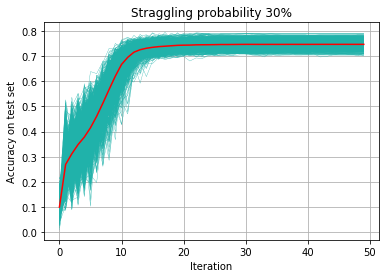

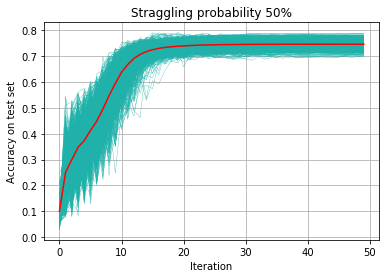

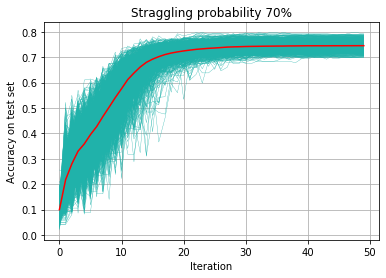

In [16]:
print("Accuracies for iid data")

for i_p, (p, cd_list) in enumerate(p_cd_list):

    fig, ax = plot_simulation_accuracies(accuracies_iid[i_p])
    ax.set_title(f"Straggling probability {int(100*p)}%")

In [17]:
# Run simulations for non-iid dirichlet data for different straggling probabilities

accuracies_dirichlet = np.zeros((num_p_scenarios, n_sim, n_iter))
moments_dirichlet = np.zeros((num_p_scenarios, n_sim, n_iter))

for i_p, (p, cd_list) in enumerate(p_cd_list):

    for i_sim in tqdm(range(n_sim), desc=f"Running simulations for p = {p}"):

        datasets_workers = dirichlet_data(alpha)

        accuracies, moments = run_simulation(p, datasets_workers)

        accuracies_dirichlet[i_p, i_sim, :] = accuracies
        moments_dirichlet[i_p, i_sim, :] = moments

np.save("saved/accuracies_dirichlet", accuracies_dirichlet)
np.save("saved/moments_dirichlet", moments_dirichlet)

Running simulations for p = 0.7: 100%|██████████| 1000/1000 [11:36<00:00,  1.43it/s]


Accuracies for Dirichlet data


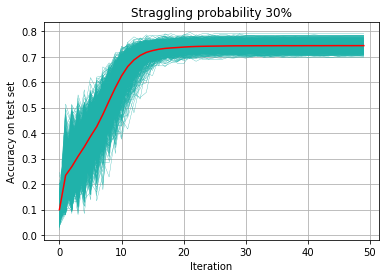

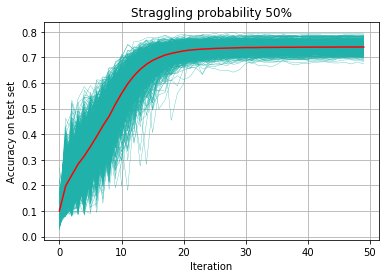

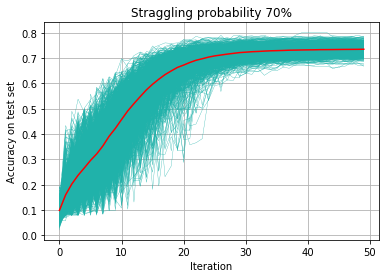

In [18]:
print("Accuracies for Dirichlet data")

for i_p, (p, cd_list) in enumerate(p_cd_list):

    fig, ax = plot_simulation_accuracies(accuracies_dirichlet[i_p])
    ax.set_title(f"Straggling probability {int(100*p)}%")

In [19]:
# Run simulations for non-iid dirichlet data with randomized sharing for different straggling probabilities and data sharing parameters

accuracies_dirichlet_random_sharing = np.zeros(
    (num_p_scenarios, num_cd_scenarios, n_sim, n_iter)
)
moments_dirichlet_random_sharing = np.zeros(
    (num_p_scenarios, num_cd_scenarios, n_sim, n_iter)
)

for i_p, (p, cd_list) in enumerate(p_cd_list):

    for i_cd, (c, d) in enumerate(cd_list):

        for i_sim in tqdm(
            range(n_sim), desc=f"Running simulations for p = {p}, c = {c}, d = {d}"
        ):
            datasets_workers = dirichlet_data(alpha)
            datasets_workers = randomized_data_sharing(datasets_workers, c, d)

            accuracies, moments = run_simulation(p, datasets_workers)

            accuracies_dirichlet_random_sharing[i_p, i_cd, i_sim, :] = accuracies
            moments_dirichlet_random_sharing[i_p, i_cd, i_sim, :] = moments

np.save(
    "saved/accuracies_dirichlet_random_sharing", accuracies_dirichlet_random_sharing
)
np.save("saved/moments_dirichlet_random_sharing", moments_dirichlet_random_sharing)

Running simulations for p = 0.7, c = 0.5, d = 4: 100%|██████████| 1000/1000 [15:41<00:00,  1.06it/s]


Accuracies for Dirichlet data with randomized sharing


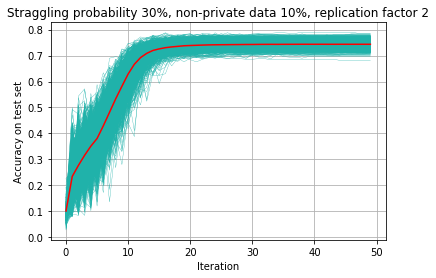

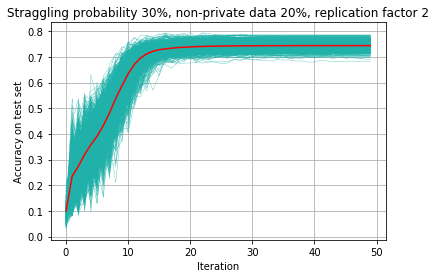

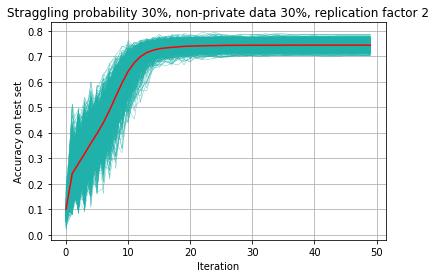

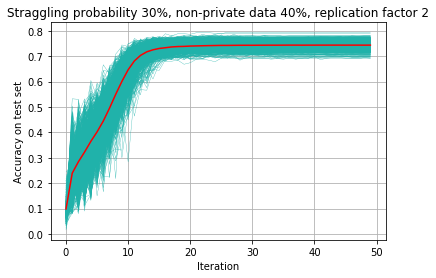

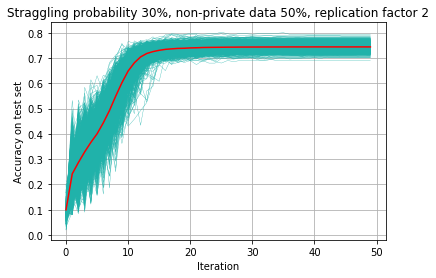

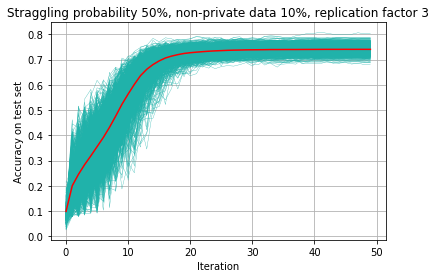

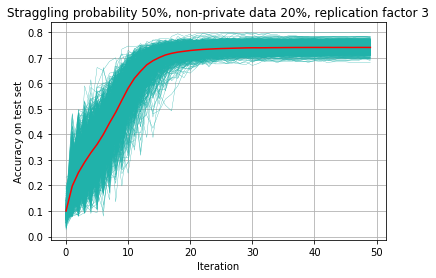

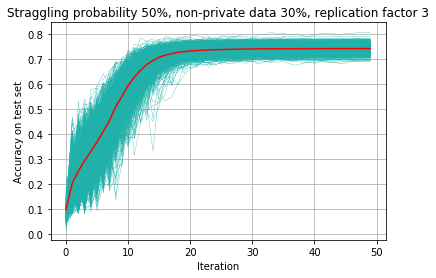

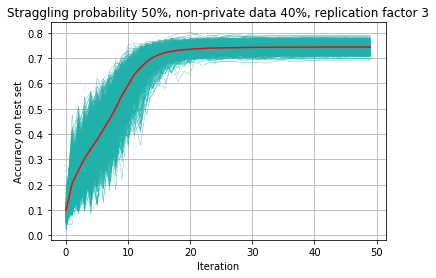

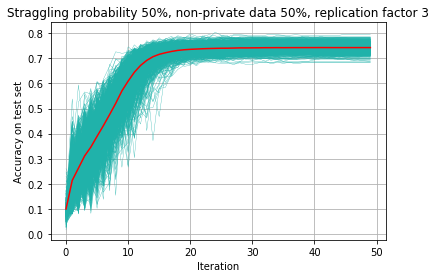

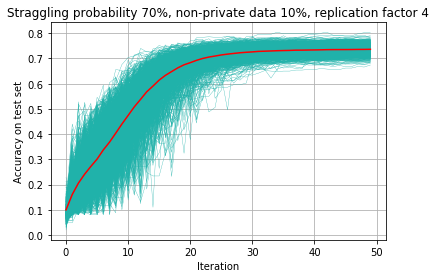

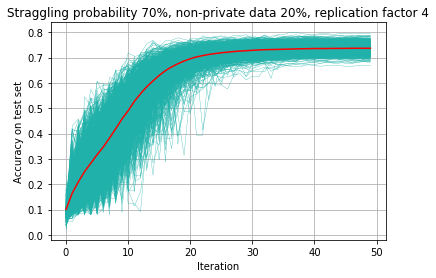

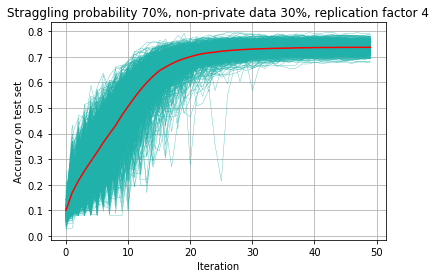

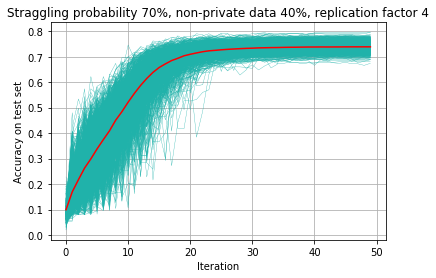

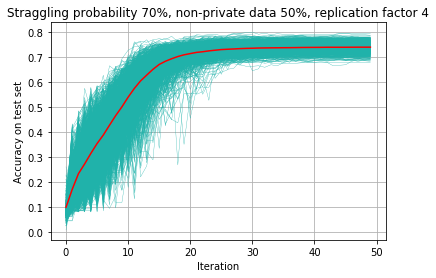

In [20]:
print("Accuracies for Dirichlet data with randomized sharing")

for i_p, (p, cd_list) in enumerate(p_cd_list):

    for i_cd, (c, d) in enumerate(cd_list):

        fig, ax = plot_simulation_accuracies(
            accuracies_dirichlet_random_sharing[i_p, i_cd]
        )
        ax.set_title(
            f"Straggling probability {int(100*p)}%, non-private data {int(100*c)}%, replication factor {d}"
        )

In [21]:
# Run simulations for heterogeneous data for different straggling probabilities

accuracies_heterogeneous = np.zeros((num_p_scenarios, n_sim, n_iter))
moments_heterogeneous = np.zeros((num_p_scenarios, n_sim, n_iter))

for i_p, (p, cd_list) in enumerate(p_cd_list):

    for i_sim in tqdm(range(n_sim), desc=f"Running simulations for p = {p}"):

        datasets_workers = heterogeneous_data()

        accuracies, moments = run_simulation(p, datasets_workers)

        accuracies_heterogeneous[i_p, i_sim, :] = accuracies
        moments_heterogeneous[i_p, i_sim, :] = moments

np.save("saved/accuracies_heterogeneous", accuracies_heterogeneous)
np.save("saved/moments_heterogeneous", moments_heterogeneous)

Running simulations for p = 0.7: 100%|██████████| 1000/1000 [11:45<00:00,  1.42it/s]


Accuracies for heterogeneous data


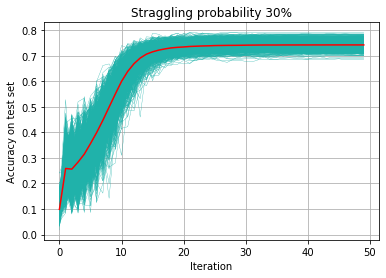

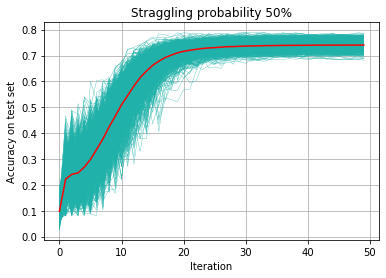

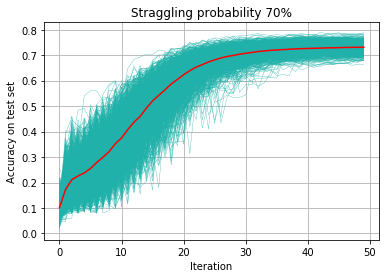

In [22]:
print("Accuracies for heterogeneous data")

for i_p, (p, cd_list) in enumerate(p_cd_list):

    fig, ax = plot_simulation_accuracies(accuracies_heterogeneous[i_p])
    ax.set_title(f"Straggling probability {int(100*p)}%")

In [23]:
# Run simulations for heterogeneous data with randomized sharing for different straggling probabilities and data sharing parameters

accuracies_heterogeneous_random_sharing = np.zeros(
    (num_p_scenarios, num_cd_scenarios, n_sim, n_iter)
)
moments_heterogeneous_random_sharing = np.zeros(
    (num_p_scenarios, num_cd_scenarios, n_sim, n_iter)
)

for i_p, (p, cd_list) in enumerate(p_cd_list):

    for i_cd, (c, d) in enumerate(cd_list):

        for i_sim in tqdm(
            range(n_sim), desc=f"Running simulations for p = {p}, c = {c}, d = {d}"
        ):

            datasets_workers = heterogeneous_data()
            datasets_workers = randomized_data_sharing(datasets_workers, c, d)

            accuracies, moments = run_simulation(p, datasets_workers)

            accuracies_heterogeneous_random_sharing[i_p, i_cd, i_sim, :] = accuracies
            moments_heterogeneous_random_sharing[i_p, i_cd, i_sim, :] = moments

np.save(
    "saved/accuracies_heterogeneous_random_sharing",
    accuracies_heterogeneous_random_sharing,
)
np.save(
    "saved/moments_heterogeneous_random_sharing", moments_heterogeneous_random_sharing
)

Running simulations for p = 0.7, c = 0.5, d = 4: 100%|██████████| 1000/1000 [14:59<00:00,  1.11it/s]


Accuracies for heterogeneous data with randomized sharing


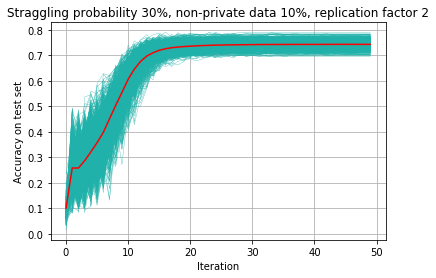

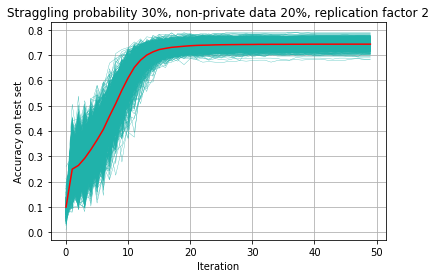

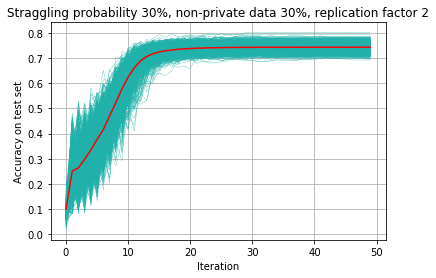

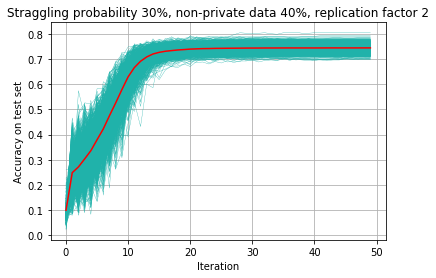

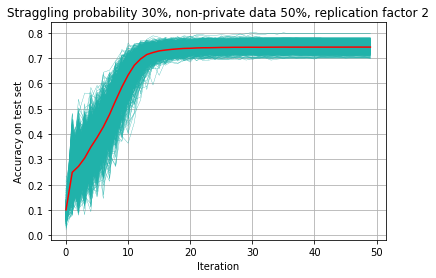

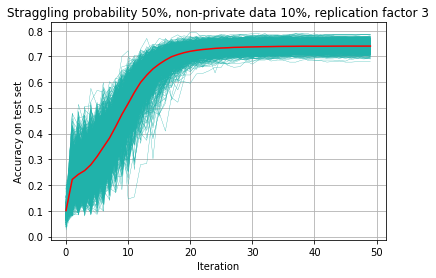

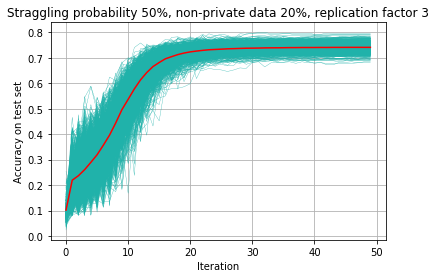

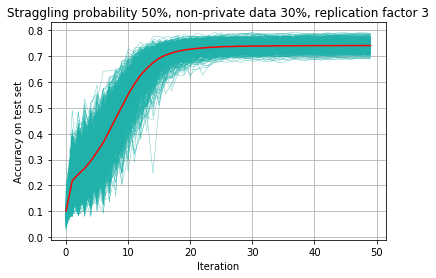

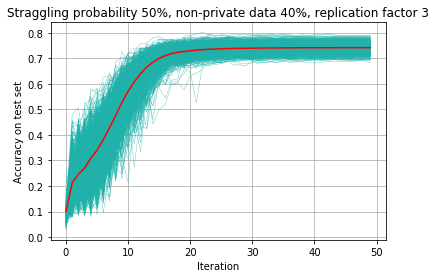

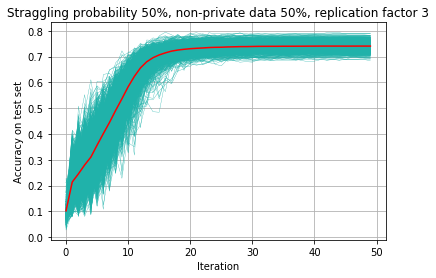

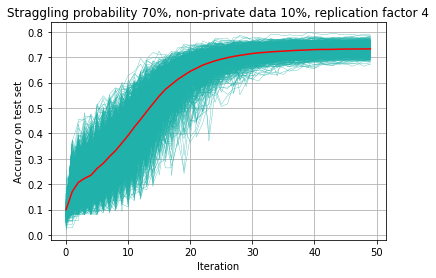

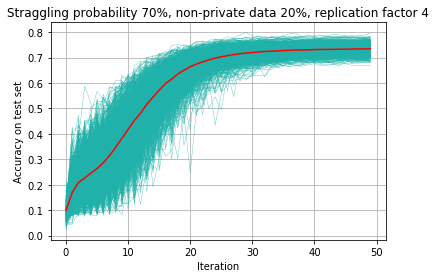

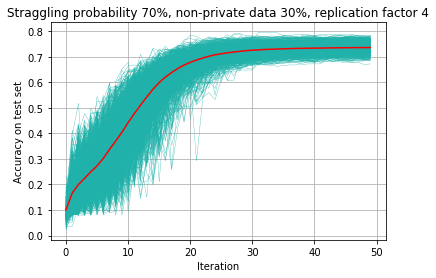

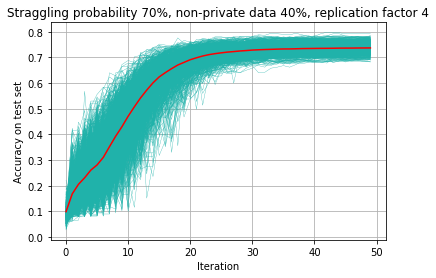

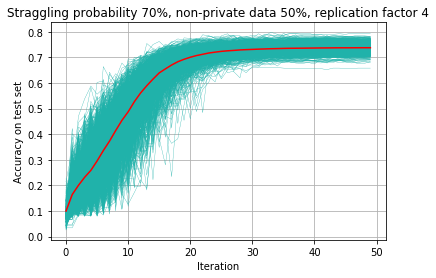

In [24]:
print("Accuracies for heterogeneous data with randomized sharing")

for i_p, (p, cd_list) in enumerate(p_cd_list):

    for i_cd, (c, d) in enumerate(cd_list):

        fig, ax = plot_simulation_accuracies(
            accuracies_heterogeneous_random_sharing[i_p, i_cd]
        )
        ax.set_title(
            f"Straggling probability {int(100*p)}%, non-private data {int(100*c)}%, replication factor {d}"
        )